# Mini-project n°2 – Conditional VAEs

Voici la bibliographie que nous avons utilisé : 
- https://towardsdatascience.com/conditional-variational-autoencoders-for-text-to-image-generation-1996da9cefcb/
- https://creatis-myriad.github.io/tutorials/2022-09-12-tutorial-cvae.html#introduction


## MNIST data-set and librairies

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torchvision.transforms.functional as functional
import torch.nn as nn
from torchvision.datasets import FashionMNIST 
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### On télécharge le dataset MNIST

In [5]:
transform = transforms.Compose([transforms.ToTensor(),])

train_dataset = FashionMNIST(root=".",train=True,download=True,transform=transform)
test_dataset = FashionMNIST(root=".",train=False,download=True,transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=False)

print("taille du data_set d'entrainement:",len(train_dataset))
print("taille du data_set de test:",len(test_dataset))

taille du data_set d'entrainement: 60000
taille du data_set de test: 10000


On visualise un exemple de chaque classe

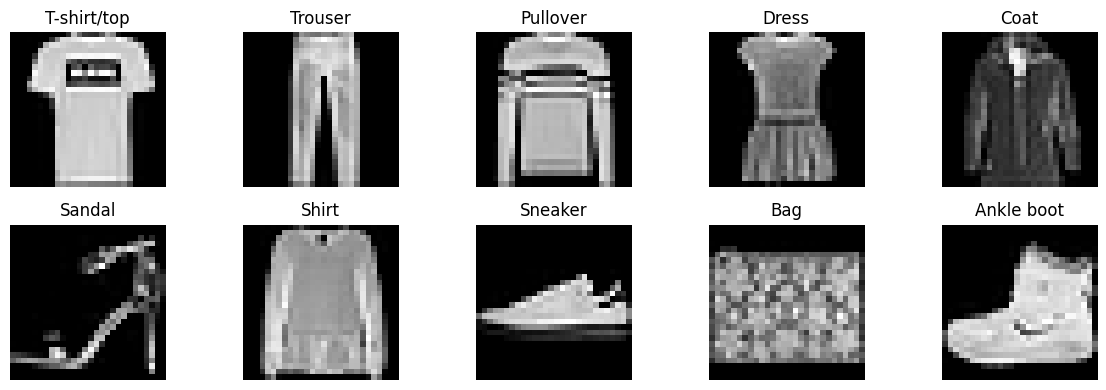

In [6]:
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat","Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"] # Les 10 classes de Fashion-MNIST
label_size=10
examples = {}

for img, label in train_dataset:
    if label not in examples:
        examples[label] = img
    if len(examples) == 10:
        break

# Affichage
plt.figure(figsize=(12, 4))
for label, img in examples.items():
    plt.subplot(2, 5, label + 1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(classes[label])
    plt.axis("off")

plt.tight_layout()
plt.show()

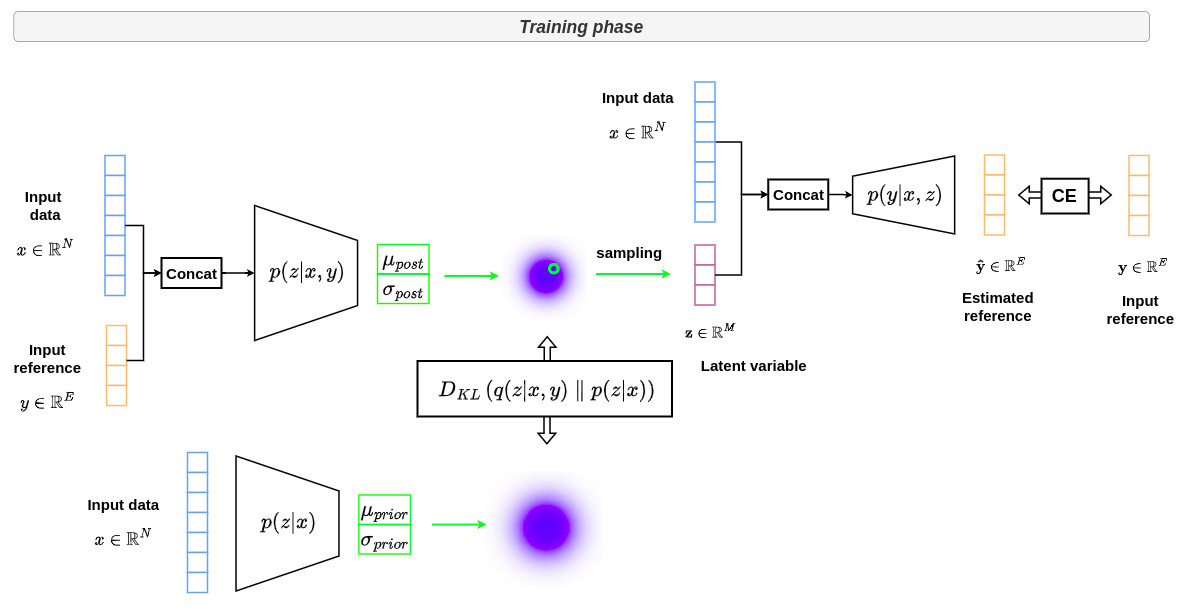

In [7]:
class cVAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(cVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = label_size                                         # On a besoin de l'info du nombre de label

        self.embedding = nn.Embedding(self.num_classes, self.num_classes)
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1+label_size, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),   # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim) 
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim) 
        self.fc_decode = nn.Linear(latent_dim + label_size, 128 * 4 * 4) 
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )
    
    def encode(self, x, y):
        y_one_hot = F.one_hot(y, num_classes=self.num_classes).float()
        y_img = y_one_hot.unsqueeze(2).unsqueeze(3)      # (batch, 10, 1, 1)
        y_img = y_img.expand(-1, -1, 28, 28)             # (batch, 10, 28, 28)

        x_cond = torch.cat([x, y_img], dim=1)            # (batch, 1+10, 28, 28)

        h = self.encoder(x_cond)                         # passes through conv layers
        h = h.view(-1, 128 * 4 * 4)

        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, y):
        y_one_hot = F.one_hot(y, num_classes=self.num_classes).float()        # (batch, 10)
        z_cond = torch.cat([z, y_one_hot], dim=1)  # (batch, latent_dim + label_size)

        x = self.fc_decode(z_cond)
        x = x.view(-1, 128, 4, 4)
        return self.decoder(x)

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.sample(mu, logvar)
        return self.decode(z, y), mu, logvar


In [8]:
def loss_function(recon_x, x, mu, logvar, beta):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD

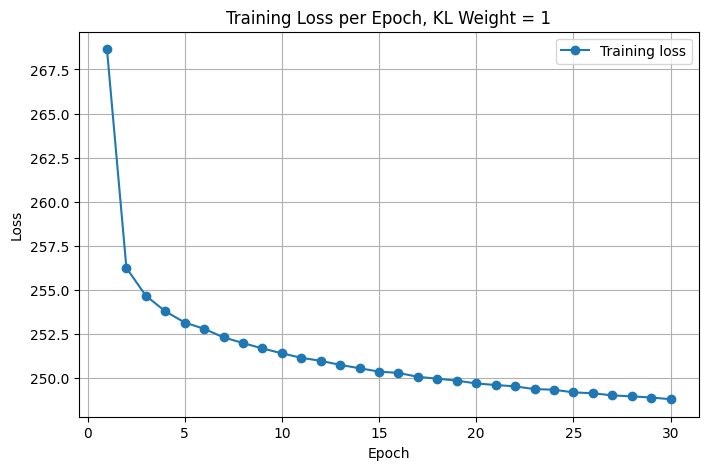

In [9]:
# Hyperparameters
batch_size = 128
latent_dim = 2
learning_rate = 1e-3
epochs = 30
beta = 1


# Initialize the VAE model and the Adam optimizer
def Train(beta): # On passe beta en paramètre pour plus tard (quand on regarde son influence sur l'espace latent)
    cvae = cVAE(latent_dim=latent_dim)
    cvae.to(device)
    optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

    losses = []

    # Train the model for the given number of epochs
    # At the end of each epoch, print the training loss
    for epoch in range(1, epochs + 1):
        cvae.train()
        running_loss = 0.0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            recon_batch, mu, logvar = cvae(data, labels)
            loss,_,_ = loss_function(recon_batch, data, mu, logvar,beta)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader.dataset)
        losses.append(epoch_loss)
        #print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')


    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), losses, marker='o', label='Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss per Epoch, KL Weight = {beta}')
    plt.grid(True)
    plt.legend()
    plt.show()
    return cvae
CVAE_1 = Train(beta)

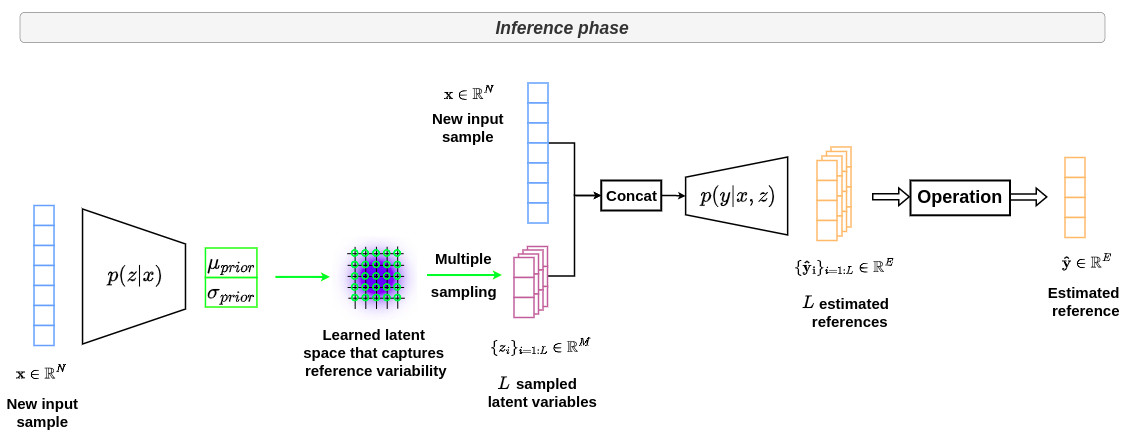

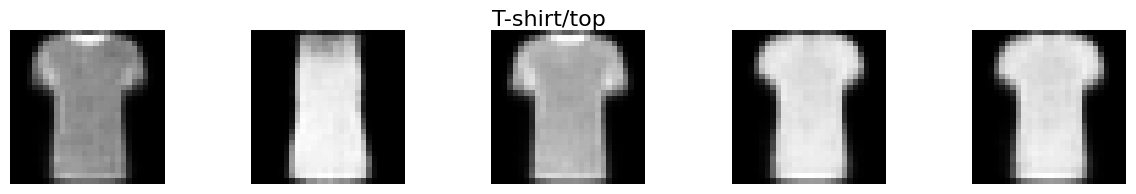

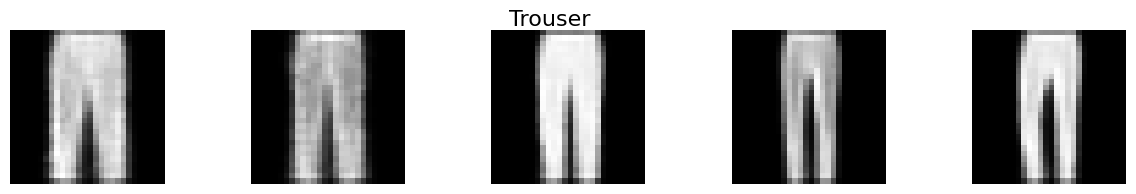

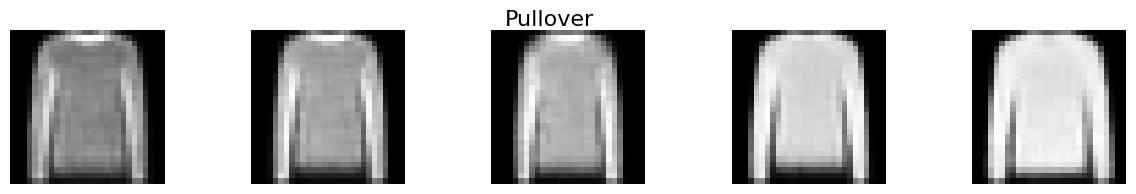

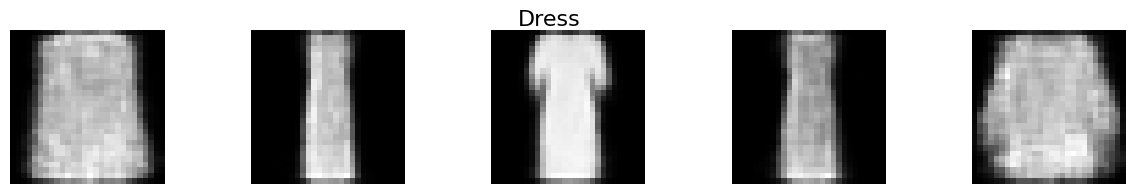

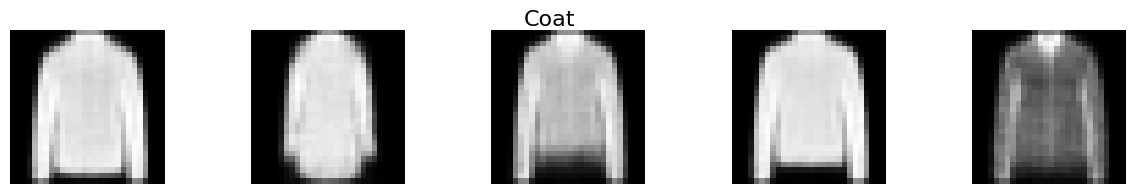

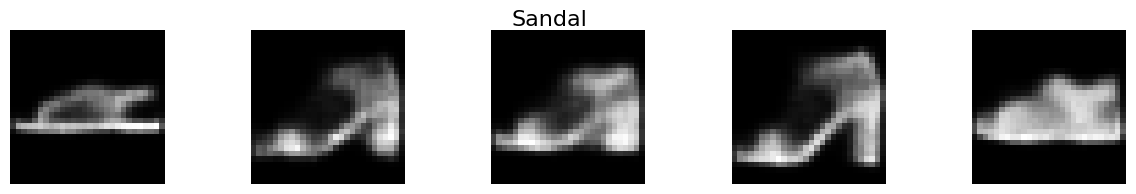

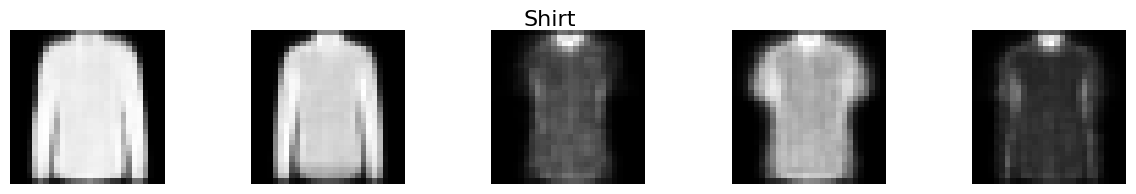

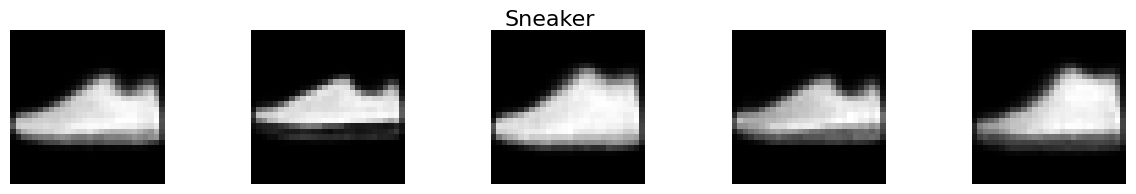

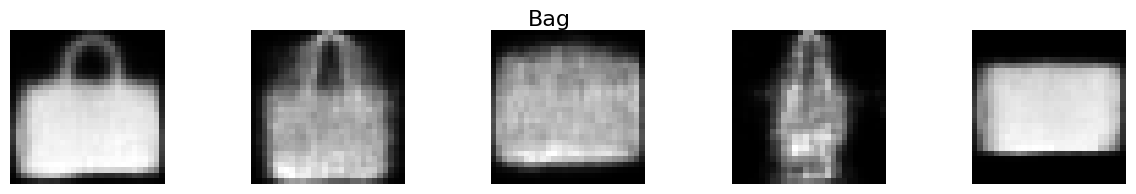

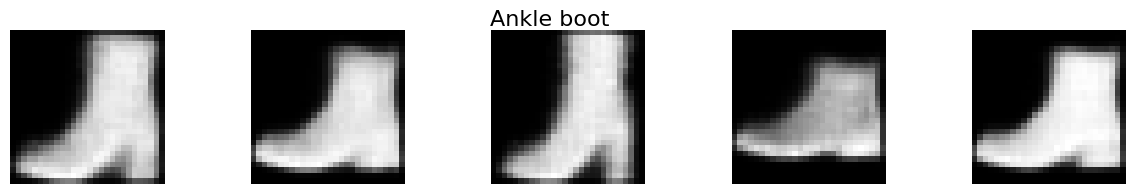

In [10]:
CVAE_1.eval()
n_samples = 5  # nombre d'images par classe
for class_idx, class_name in enumerate(classes):
    plt.figure(figsize=(15, 2))
    plt.suptitle(class_name, fontsize=16)
    
    for i in range(n_samples):
        y = torch.tensor([class_idx], device=device)
        z = torch.randn(1, latent_dim).to(device)
        generated = CVAE_1.decode(z, y).detach().cpu().squeeze()
        
        plt.subplot(1, n_samples, i+1)
        plt.imshow(generated, cmap="gray")
        plt.axis('off')
    
    plt.show()

## Visualisation de l'espace latent

Notre espace latent est en 2 dimensions, donc on va pouvoir le visualiser.
On va en profiter pour regarder l'impact du poids que l'on donne au KL dans la fonction de loss.

On va regarder 3 modèles différents: CVAE_1, CVAE_10 et CVAE_100. Ces trois modèles sont les memes, la seule chose qui change est la valeur du poids $\beta$ du KL dans la fonction de perte: 1,10 et 100.
  

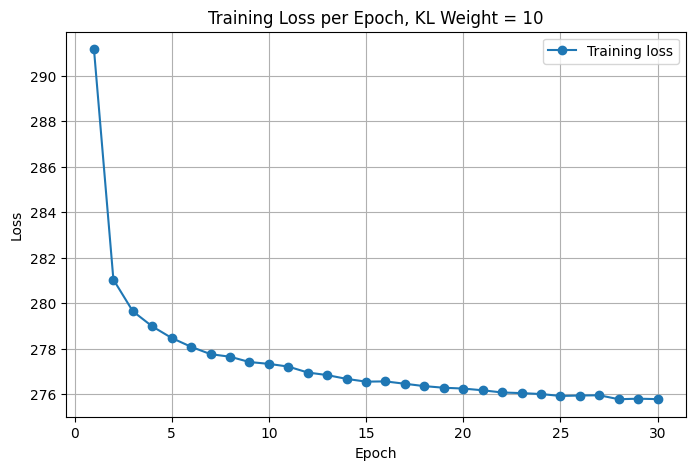

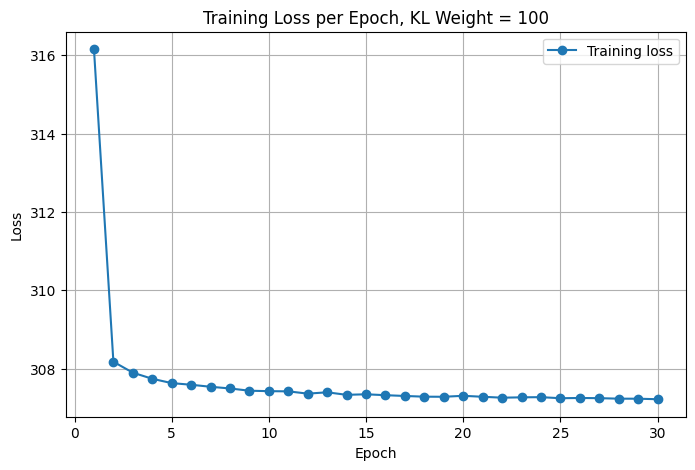

In [12]:
CVAE_10 = Train(10)
CVAE_100 = Train(100)


Pour comparer l'impact du poids $\beta$ sur l'organisation de l'espace latent on fait une fonction qui : 
    - Pour chaque modèle,  encode toutes les images du jeu de test afin de récupérer les moyennes $\mu$ des distributions latentes.  
    - Elle concatène toutes les latentes et les labels correspondants pour créer un nuage de points en 2 dimensions.  
    - Elle trace chaque point dans un scatter plot, en utilisant une couleur différente pour chaque classe d'image.  

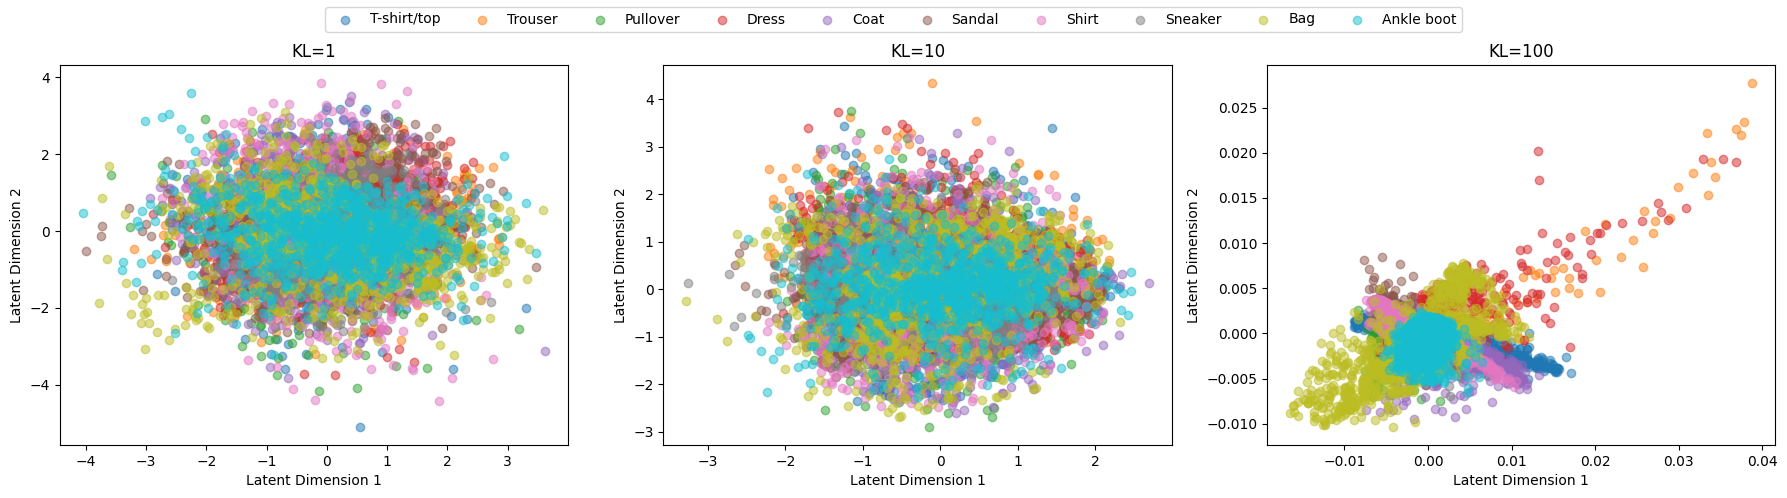

In [20]:
def Visualiser_espaces_latents(models, titles):
    """
    Visualise les espaces latents de plusieurs modèles
    
    models : list de modèles
    titles : list de titres correspondants à chaque modèle
    """
    num_models = len(models)
    fig, axes = plt.subplots(1, num_models, figsize=(6*num_models, 5))

    for ax, model, title in zip(axes, models, titles):
        model.eval()
        latents = []
        labels_list = []

        with torch.no_grad():
            for data, labels in test_loader:
                data = data.to(device)
                labels = labels.to(device)
                
                mu, logvar = model.encode(data, labels)
                latents.append(mu.cpu())
                labels_list.append(labels.cpu())

        latents = torch.cat(latents, dim=0)
        labels_list = torch.cat(labels_list, dim=0)

        for i in range(10):
            idxs = labels_list == i
            ax.scatter(latents[idxs, 0], latents[idxs, 1], label=classes[i], alpha=0.5)

        ax.set_xlabel("Latent Dimension 1")
        ax.set_ylabel("Latent Dimension 2")
        ax.set_title(title)

    # On affiche la légende une seule fois pour toute la figure
    handles, labels_ = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels_, loc='upper center', ncol=10)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()


# Exemple d'appel
Visualiser_espaces_latents(
    models=[CVAE_1, CVAE_10, CVAE_100],
    titles=["KL=1", "KL=10", "KL=100"]
)


Pour rappel, la loss est calculé par:  
**Loss = BCE + $\beta$ KLD**  
avec :
- BCE (Binary Cross Entropy) qui mesure la qualité de reconstruction des images.
- KLD (Kullback-Leibler Divergence) qui force la distribution latente q(z∣x) à se rapprocher d’une distribution normale standard N(0,1). Et on ajoute un poids beta devant KLD 

On remarque que plus le poids donné à KL est important, plus on arrive à discerner les catégories dans l'espace latent. **C'est l'opposé de ce qu'on voyait avec le VAE classique qu'on a fait en TP ???**

On va maintenant regarder ce qu'il se passe lors de la génération.
On visualise comment les images générées évoluent lorsque l'on parcourt une grille régulière dans le plan latent pour une classe donnée. 
Pour chaque modèle et chaque classe sélectionnée, nous générons des images à partir de coordonnées latentes $(z_1, z_2)$ uniformément espacées dans un intervalle choisi. 
Ces images sont ensuite assemblées pour former une grande grille représentant le "manifold latent" de la classe.

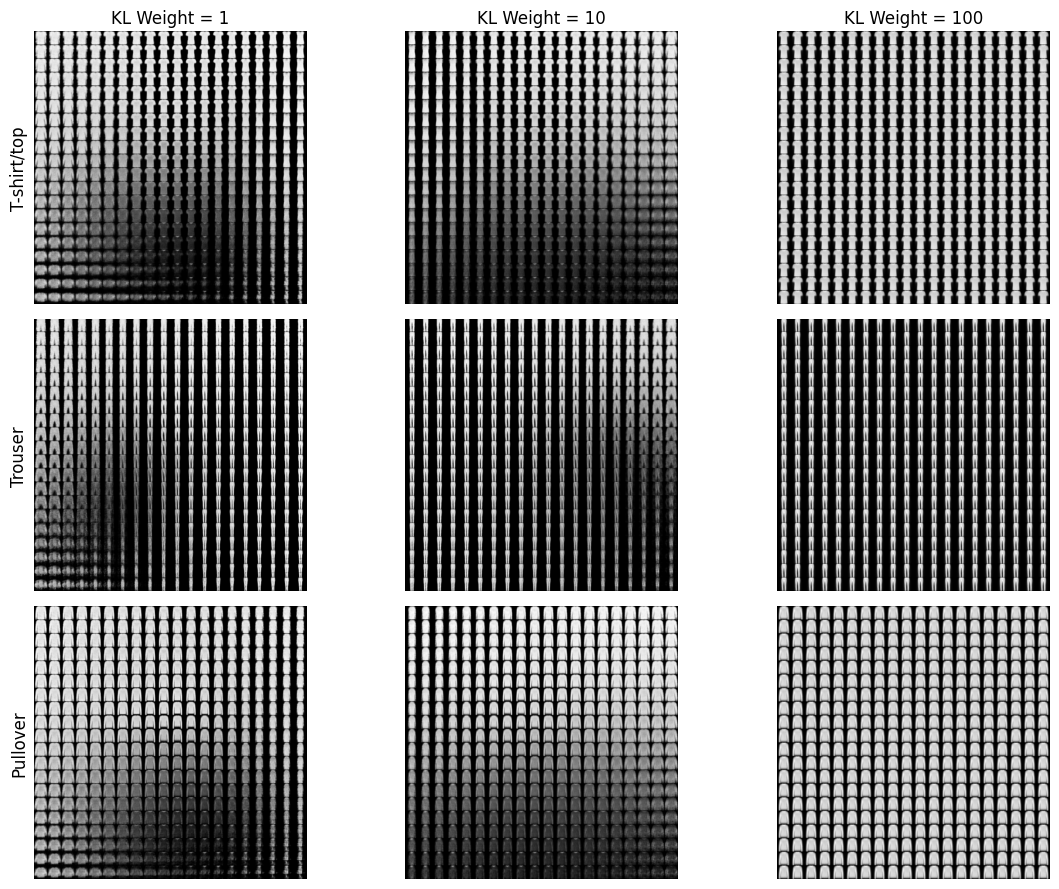

In [14]:
def plot_latent_manifolds_grid(models, betas, labels, device, grid_size=20, scale=3):

    n_labels = len(labels)
    fig, axes = plt.subplots(n_labels, len(models), figsize=(4*len(models), 3*n_labels))

    # Si 1 seul label → axes devient 1D, on force en 2D
    if n_labels == 1:
        axes = axes[np.newaxis, :]

    for row, label in enumerate(labels):
        for col, (model, beta) in enumerate(zip(models, betas)):
            
            model.eval()
            z1 = np.linspace(-scale, scale, grid_size)
            z2 = np.linspace(-scale, scale, grid_size)
            figure = np.zeros((28 * grid_size, 28 * grid_size))

            with torch.no_grad():
                for i, yi in enumerate(z1):
                    for j, xj in enumerate(z2):
                        z = torch.tensor([[yi, xj]], dtype=torch.float32).to(device)
                        y_tensor = torch.tensor([label], dtype=torch.long).to(device)
                        x_hat = model.decode(z, y_tensor)
                        img = x_hat.cpu().view(28, 28).numpy()
                        figure[i*28:(i+1)*28, j*28:(j+1)*28] = img
            
            ax = axes[row, col]
            ax.imshow(figure, cmap="gray")
            ax.set_xticks([])
            ax.set_yticks([])
            ax.tick_params(axis='both', which='both', length=0)
            for spine in ax.spines.values():
                spine.set_visible(False)

            # Titres
            if row == 0:
                ax.set_title(f"KL Weight = {beta}", fontsize=12)

            if col == 0:
                ax.set_ylabel(classes[label], fontsize=12)

    plt.tight_layout()
    plt.show()


plot_latent_manifolds_grid(
    models=[CVAE_1, CVAE_10, CVAE_100],
    betas=[1, 10, 100],
    labels=[0,1,2],             # On choisit ici les habits qu'on veut afficher !
    device=device
)


On observe que plus la valeur de KL Weight ($\beta$) est elevée, plus le modèle arrive à générer la bonne image. Par contre l'espace latent devient plus uniforme. 
Quand on a KL Weight = 100, peut importe la valeur de (z1,z2) on aura la même sortie. Par contre on a beaucoup plus de diversité quand KL Weight est plus bas. Cela peut engendrer des génération incohérentes, mais il y aura de la diversité.

On voit aussi que le modèle mélange les Sandales et les Sneakers pour une valeur plutot faible de $\beta$.

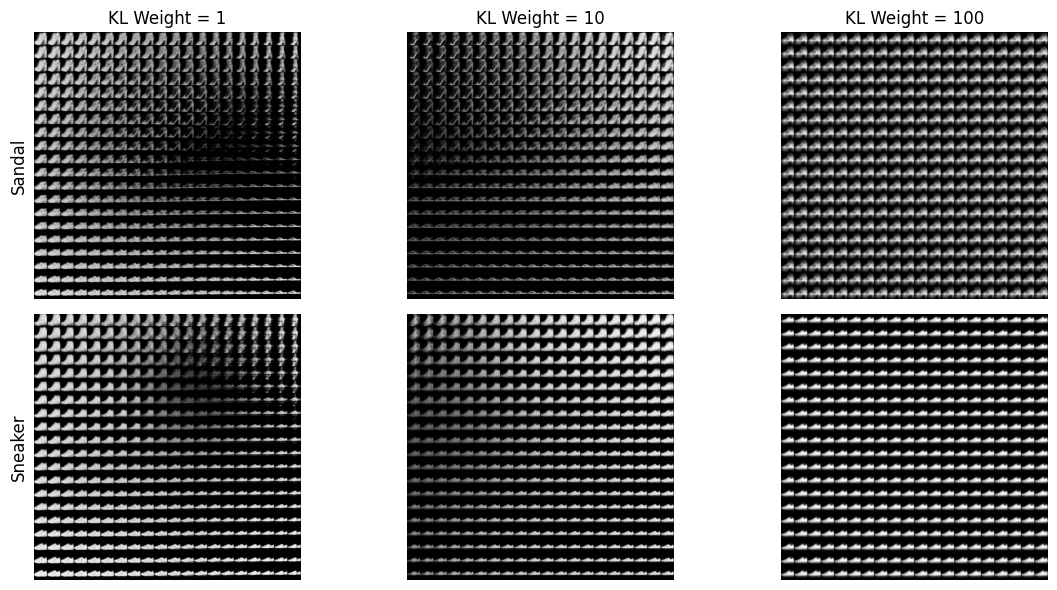

In [15]:
plot_latent_manifolds_grid(models=[CVAE_1, CVAE_10, CVAE_100],betas=[1, 10, 100],labels=[5,7],device=device)